In [1]:
import csv
import pandas as pd
import numpy as np
from transformers import pipeline
import matplotlib.pyplot as plt
from IPython.display import FileLink
from tqdm.auto import tqdm

# Caminhos dos CSVs (proposições e autores)
CSV_PROP = "proposicoes-detalhes.csv"
CSV_AUT  = "proposicoes-autores.csv"

# Número de projetos para olhar em detalhe
TOP_N = 20  # para visualizar detalhadamente os mais relevantes

# Mapeamento de partido -> eixo ideológico
PARTY_AXIS = {
    "PT": "Esquerda",
    "PCdoB": "Esquerda",
    "PSOL": "Esquerda",
    "PSTU": "Esquerda",
    "PCB": "Esquerda",
    "UP": "Esquerda",
    "PCO": "Esquerda",
    "PDT": "Centro-esquerda",
    "PSB": "Centro-esquerda",
    "CIDADANIA": "Centro-esquerda",
    "PV": "Centro-esquerda",
    "REDE": "Centro-esquerda",
    "MDB": "Centro",
    "PSD": "Centro",
    "PSDB": "Centro",
    "AVANTE": "Centro",
    "SOLIDARIEDADE": "Centro",
    "PMB": "Centro",
    "PP": "Centro-direita",
    "AGIR": "Centro-direita",
    "PMN": "Centro-direita",
    "MOBILIZA": "Centro-direita",
    "UNIÃO": "Centro-direita",
    "PRD": "Centro-direita",
    "PRTB": "Direita",
    "REPUBLICANOS": "Direita",
    "PL": "Direita",
    "NOVO": "Direita",
    "DC": "Direita",
    "PODE": "Direita",
}

# Definição dos temas para zero-shot multi-rótulo
TOPIC_LABELS = [
    "sistema prisional e segurança pública",
    "sistema público de saúde e sistema suplementar de saúde",
    "direito de populações indígenas",
    "ensino infantil, ensino fundamental, ensino médio ou ensino superior",
]

# Versão "curta" para nomear colunas de score
TOPIC_KEYS = {
    "sistema prisional e segurança pública": "pris_segpub",
    "sistema público de saúde e sistema suplementar de saúde": "saude",
    "direito de populações indígenas": "indigena",
    "ensino infantil, ensino fundamental, ensino médio ou ensino superior": "educacao",
}

HYPOTHESIS_TEMPLATE = "Este texto é sobre {}."

# Limiar para considerar que um tema realmente vale para o texto
THRESHOLD = 0.5  # ajuste conforme necessário

# Tema padrão para ordenar visualizações/exports (pode trocar para qualquer key de TOPIC_KEYS)
THEME_KEY = "pris_segpub"  # por padrão: sistema prisional e segurança pública


In [2]:
csv.field_size_limit(10**7)

# Carrega proposições
df_prop = pd.read_csv(
    CSV_PROP,
    sep=";",
    engine="python",
    quoting=csv.QUOTE_ALL,
    encoding="utf-8",
)
df_prop["id"] = df_prop["id"].astype(int)

# Carrega autores
df_autores = pd.read_csv(
    CSV_AUT,
    sep=";",
    engine="python",
    quoting=csv.QUOTE_ALL,
    encoding="utf-8",
)
df_autores["id_proposicao"] = df_autores["id_proposicao"].astype(int)
df_autores["id_autor"] = df_autores["id_autor"].astype(int)

print("Proposições em df_prop:", df_prop["id"].nunique())
print("Proposições em df_autores:", df_autores["id_proposicao"].nunique())

df_prop.head(), df_autores.head()


Proposições em df_prop: 5311
Proposições em df_autores: 4989


(        id siglaTipo  numero   ano   descricaoTipo  \
 0  2481874        PL       1  2025  Projeto de Lei   
 1  2481875        PL       2  2025  Projeto de Lei   
 2  2482075        PL       5  2025  Projeto de Lei   
 3  2482076        PL       6  2025  Projeto de Lei   
 4  2482079        PL       7  2025  Projeto de Lei   
 
                                               ementa  \
 0  Dispõe sobre a criação de oito varas federais ...   
 1  Dispõe sobre a reestruturação de cargos da mag...   
 2  Proíbe a utilização de recursos públicos para ...   
 3  Dispõe sobre a inclusão de disposições no Códi...   
 4  Altera a Lei nº 8.078 de 11 de setembro de 199...   
 
                                      ementaDetalhada  \
 0                                                NaN   
 1                                                NaN   
 2                                                NaN   
 3  Altera o Decreto-Lei nº 3.689, de 3 de Outubro...   
 4                                     

In [3]:
# Classifica autores em eixos ideológicos com base no partido
df_autores["eixo_ideologico"] = (
    df_autores["siglaPartido"]
    .map(PARTY_AXIS)
    .fillna("Sem classificação")
)

df_autores[[
    "id_proposicao",
    "nome_autor",
    "siglaPartido",
    "siglaUf",
    "eixo_ideologico",
]].head()


,id_proposicao,nome_autor,siglaPartido,siglaUf,eixo_ideologico
0,2482075,Marcelo Álvaro Antônio,PL,MG,Direita
1,2482076,Marcelo Álvaro Antônio,PL,MG,Direita
2,2482079,Duarte Jr.,PSB,MA,Centro-esquerda
3,2482081,Duarte Jr.,PSB,MA,Centro-esquerda
4,2482081,Duda Ramos,MDB,RR,Centro


In [4]:
# Zero-shot multi-tema com base na ementa

# Texto base: apenas a ementa
textos_prop = df_prop["ementa"].fillna("")

# Modelo de zero-shot (NLI multilíngue)
MODEL_NAME = "joeddav/xlm-roberta-large-xnli"

classifier = pipeline(
    "zero-shot-classification",
    model=MODEL_NAME,
    device=-1,  # CPU; ajuste para 0 se houver GPU
)

def classificar_ementa_multitema(texto):
    """Classifica a ementa em múltiplos temas.

    Retorna:
      - scores por tema
      - tema primário (label_primaria)
      - score do tema primário
      - lista de temas com score >= THRESHOLD
      - flag de categoria residual (eh_residual)
    """
    if not isinstance(texto, str) or texto.strip() == "":
        base = {
            "label_primaria": None,
            "score_label_primaria": None,
            "temas_acima_threshold": None,
            "n_temas_acima_threshold": 0,
            "eh_residual": None,
        }
        for label, key in TOPIC_KEYS.items():
            base[f"score_{key}"] = None
        return pd.Series(base)

    result = classifier(
        texto,
        candidate_labels=TOPIC_LABELS,
        hypothesis_template=HYPOTHESIS_TEMPLATE,
        multi_label=True,
    )

    scores_por_label = dict(zip(result["labels"], result["scores"]))

    row = {}
    for label, key in TOPIC_KEYS.items():
        row[f"score_{key}"] = float(scores_por_label.get(label, 0.0))

    temas_acima = [
        label for label, score in scores_por_label.items()
        if score >= THRESHOLD
    ]

    label_primaria = max(scores_por_label, key=scores_por_label.get)
    score_label_primaria = float(scores_por_label[label_primaria])

    # Categoria residual: nenhum tema passou do limiar
    eh_residual = 1 if len(temas_acima) == 0 else 0

    row.update({
        "label_primaria": label_primaria if eh_residual == 0 else "Outros temas",
        "score_label_primaria": score_label_primaria,
        "temas_acima_threshold": "; ".join(temas_acima) if temas_acima else "",
        "n_temas_acima_threshold": len(temas_acima),
        "eh_residual": eh_residual,
    })

    return pd.Series(row)

tqdm.pandas(desc="Classificando proposições (zero-shot, multi-tema)")
df_topics = textos_prop.progress_apply(classificar_ementa_multitema)

# Junta com ids da proposição
df_scores = pd.DataFrame({
    "idx_prop": df_prop.index,
    "id": df_prop["id"].values,
})
CZSSZ
ZCZSdCZf_scores = pd.concat([df_scores, df_topics], axis=1)

df_scores.head()


Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


Classificando proposições (zero-shot, multi-tema):   0%|          | 0/5311 [00:00<?, ?it/s]

,idx_prop,id,score_pris_segpub,score_saude,score_indigena,score_educacao,label_primaria,score_label_primaria,temas_acima_threshold,n_temas_acima_threshold,eh_residual
0,0,2481874,0.512039,0.000343,0.000245,0.000564,sistema prisional e segurança pública,0.512039,sistema prisional e segurança pública,1,0
1,1,2481875,0.015056,0.000282,0.000174,0.000613,Outros temas,0.015056,,0,1
2,2,2482075,0.008238,0.002296,0.001658,0.004894,Outros temas,0.008238,,0,1
3,3,2482076,0.998655,0.000329,0.000255,0.002257,sistema prisional e segurança pública,0.998655,sistema prisional e segurança pública,1,0
4,4,2482079,0.000151,0.011218,0.000173,0.001178,Outros temas,0.011218,,0,1


In [5]:
# Junta scores com o dataframe de proposições
df_rank = df_scores.merge(
    df_prop,
    on="id",
    how="left",
)

print(len(df_rank))
df_rank.head()


5311


,idx_prop,id,score_pris_segpub,score_saude,score_indigena,score_educacao,label_primaria,score_label_primaria,temas_acima_threshold,n_temas_acima_threshold,...,status_sequencia,status_siglaOrgao,status_regime,status_descricaoTramitacao,status_codTipoTramitacao,status_descricaoSituacao,status_codSituacao,status_despacho,status_ambito,status_apreciacao
0,0,2481874,0.512039,0.000343,0.000245,0.000564,sistema prisional e segurança pública,0.512039,sistema prisional e segurança pública,1,...,46,MESA,"Urgência (Art. 155, RICD)",Transformação em Norma Jurídica,251,Transformado em Norma Jurídica,1140.0,Transformado na Lei Ordinária 15172/2025. DOU ...,Regimental,Proposição Sujeita à Apreciação do Plenário
1,1,2481875,0.015056,0.000282,0.000174,0.000613,Outros temas,0.015056,,0,...,49,MESA,"Urgência (Art. 155, RICD)",Apresentação de Proposição,100,Transformado em Norma Jurídica,1140.0,Recebido Ofício nº 684/2025-SF que comunica re...,Regimental,Proposição Sujeita à Apreciação do Plenário
2,2,2482075,0.008238,0.002296,0.001658,0.004894,Outros temas,0.008238,,0,...,21,CASP,"Ordinário (Art. 151, III, RICD)",Notificacao para Publicação Intermediária,1050,Tramitando em Conjunto,925.0,"Designado Relator, Dep. Ronaldo Nogueira (REPU...",Regimental,Proposição Sujeita à Apreciação Conclusiva pel...
3,3,2482076,0.998655,0.000329,0.000255,0.002257,sistema prisional e segurança pública,0.998655,sistema prisional e segurança pública,1,...,14,CCJC,"Prioridade (Art. 151, II, RICD)",Recebimento,500,Tramitando em Conjunto,925.0,Recebimento pela CCJC.,Regimental,Proposição Sujeita à Apreciação do Plenário
4,4,2482079,0.000151,0.011218,0.000173,0.001178,Outros temas,0.011218,,0,...,17,CDC,"Ordinário (Art. 151, III, RICD)",Notificacao para Publicação Intermediária,1050,Tramitando em Conjunto,925.0,"Designado Relator, Dep. Felipe Carreras (PSB-P...",Regimental,Proposição Sujeita à Apreciação do Plenário


In [6]:
# Agrega autores e eixos ideológicos por proposição
autores_agregados = (
    df_autores
    .assign(
        autor_fmt=lambda d: (
            d["nome_autor"]
            + " ("
            + d["siglaPartido"].fillna("")
            + "/"
            + d["siglaUf"].fillna("")
            + ", "
            + d["eixo_ideologico"]
            + ")"
        )
    )
    .groupby("id_proposicao")
    .agg(
        autores=("autor_fmt", lambda xs: "; ".join(sorted(set(xs)))),
        eixos_presentes=(
            "eixo_ideologico",
            lambda xs: "; ".join(sorted(set(xs)))
        ),
    )
    .reset_index()
    .rename(columns={"id_proposicao": "id"})
)

df_rank_agregado = df_rank.merge(
    autores_agregados,
    on="id",
    how="left",
)

cols_mostrar = [
    "id",
    f"score_{THEME_KEY}",
    "siglaTipo",
    "numero",
    "ano",
    "ementa",
    "autores",
    "eixos_presentes",
]

topN_agregado = (
    df_rank_agregado
    .sort_values(f"score_{THEME_KEY}", ascending=False)
    [cols_mostrar]
    .head(TOP_N)
)

pd.set_option("display.max_colwidth", 160)
topN_agregado


,id,score_pris_segpub,siglaTipo,numero,ano,ementa,autores,eixos_presentes
4537,2571246,0.999428,PL,5124,2025,"Altera a Lei nº 7.210, de 11 de julho de 1984 (Lei de Execução Penal), a fim de dispor sobre os raios de segurança máxima nos estabelecimentos prisionais.","Coronel Assis (UNIÃO/MT, Centro-direita)",Centro-direita
5158,2584505,0.999020,PL,5819,2025,"Dispõe sobre o endurecimento das penas aplicáveis ao crime de fraude eletrônica a aplicação de prisão preventiva em casos de maior gravidade, a criação do F...","Coronel Chrisóstomo (PL/RO, Direita)",Direita
431,2484144,0.998886,PL,491,2025,Institui a Política Nacional de Desenvolvimento e Aprimoramento dos Estabelecimentos Prisionais de Segurança Máxima; e dá outras providências.,"Kim Kataguiri (UNIÃO/SP, Centro-direita)",Centro-direita
445,2484269,0.998886,PL,508,2025,Institui a Política Nacional de Desenvolvimento e Aprimoramento dos Estabelecimentos Prisionais de Segurança Máxima; e dá outras providências.,"Kim Kataguiri (UNIÃO/SP, Centro-direita)",Centro-direita
5002,2581349,0.998873,PL,5640,2025,"Institui o Programa Nacional de Habitabilidade e Segurança Prisional, destinado à avaliação, regularização e certificação das condições físicas, sanitárias ...","Marcos Tavares (PDT/RJ, Centro-esquerda)",Centro-esquerda
3849,2555617,0.998742,PL,4355,2025,"Estabelece aos servidores integrantes do sistema de segurança pública, previstos no Artigo 144 da Constituição Federal, aos guardas municipais e a Polícia P...",NaN,NaN
1469,2497227,0.998739,PL,1660,2025,"Dispõe sobre a regulamentação dos procedimentos de revista em visitantes e presos no âmbito das unidades prisionais federais, proibindo a realização de revi...","Marcos Tavares (PDT/RJ, Centro-esquerda)",Centro-esquerda
3,2482076,0.998655,PL,6,2025,Dispõe sobre a inclusão de disposições no Código de Processo Penal para assegurar maior celeridade e eficácia nas investigações criminais e promover a respo...,"Marcelo Álvaro Antônio (PL/MG, Direita)",Direita
4272,2565576,0.998576,PL,4836,2025,"A presente proposição tem como objetivo endurecer a legislação penal e processual penal no enfrentamento às organizações criminosas e terroristas, reforçand...","Kim Kataguiri (UNIÃO/SP, Centro-direita)",Centro-direita
3779,2554164,0.998463,PL,4274,2025,"Aperfeiçoa a execução penal, a decretação de prisão preventiva e o tempo que configura a reincidência; elenca e conceitua organizações criminosas de enfrent...","Pedro Paulo (PSD/RJ, Centro)",Centro


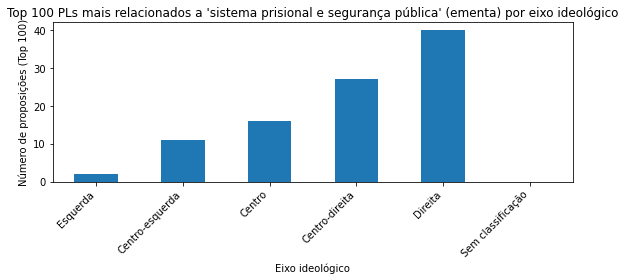

In [7]:
# Seleciona top 100 projetos mais relacionados ao tema escolhido (THEME_KEY)
score_col = f"score_{THEME_KEY}"
top100 = (
    df_rank_agregado
    .sort_values(score_col, ascending=False)
    .head(100)
    .copy()
)

# Explode dos eixos ideológicos
eixos = (
    top100[["id", "eixos_presentes"]]
    .dropna(subset=["eixos_presentes"])
    .assign(eixo=lambda d: d["eixos_presentes"].str.split(";"))
    .explode("eixo")
)

eixos["eixo"] = eixos["eixo"].str.strip()
eixos = eixos[eixos["eixo"] != ""]

# Garante unicidade por (id, eixo)
eixos = eixos.drop_duplicates(subset=["id", "eixo"])

# Ordem desejada (esquerda → direita)
ordem_eixos = [
    "Esquerda",
    "Centro-esquerda",
    "Centro",
    "Centro-direita",
    "Direita",
    "Sem classificação",
]

# Contagem por eixo
counts = eixos["eixo"].value_counts()
counts = counts.reindex(ordem_eixos, fill_value=0)

# Título legível usando o label do tema
key_to_label = {v: k for k, v in TOPIC_KEYS.items()}
tema_label = key_to_label.get(THEME_KEY, THEME_KEY)

# Gráfico de barras
plt.figure(figsize=(8, 4))
counts.plot(kind="bar")
plt.xlabel("Eixo ideológico")
plt.ylabel("Número de proposições (Top 100)")
plt.title(f"Top 100 PLs mais relacionados a '{tema_label}' (ementa) por eixo ideológico")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [8]:
# Salva os rankings em CSV
# Mantemos um nome similar ao anterior para o tema prisional,
# mas o conteúdo agora traz múltiplos temas.

topN_agregado.to_csv(
    "topN_sistema_prisional_ementa.csv",
    index=False,
    encoding="utf-8-sig",
)

df_rank_agregado.to_csv(
    "todos_projetos_multitema_ementa.csv",
    index=False,
    encoding="utf-8-sig",
)

# Links para download no notebook
display(FileLink("topN_sistema_prisional_ementa.csv"))
display(FileLink("todos_projetos_multitema_ementa.csv"))


/home/lasagna/cebrap-lab-ia-r-python/tutorial/topN_sistema_prisional_ementa.csv

/home/lasagna/cebrap-lab-ia-r-python/tutorial/todos_projetos_multitema_ementa.csv